## 1. Outline

1. Using torchvision.datasets with a custom folder of images
2. Occlusion analysis with pretrained model
3. Filter visualisation with pretrained model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os 

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import copy
import time

import warnings
warnings.filterwarnings('ignore')

## 2. Custom Torchvision Dataset

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
file_path = '/gdrive/My Drive/Colab Notebooks/padh.ai.notebooks/9. CNN with PyTorch/CNN Visualization - padh.ai'
os.listdir()

['.config', 'sample_data']

In [0]:
file = 'data.zip'

if not os.path.exists(os.path.join(file_path,'data')):
  file = zipfile.ZipFile(file,'r')
  file.extractall(file_path)
  file.close()
  
root_dir = os.path.join(file_path,'data')
os.chdir(root_dir)

In [0]:
images = os.path.join(root_dir,'imagenet','1')
with open('imagenet_labels.txt','r') as labels:
  classes = eval(labels.read())

In [6]:
print(type(classes))
print(classes)

<class 'dict'>
{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 2

In [0]:
# accessing the image folder using torchvision 
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

evalset = torchvision.datasets.ImageFolder(root=os.path.join(root_dir,'imagenet'), transform = transform)

In [8]:
batch_size = 1
eval_dataloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)

dataiter = iter(eval_dataloader)
images, labels = dataiter.next()

print(images.size())
print(labels)

torch.Size([1, 3, 224, 224])
tensor([0])


In [0]:
def return_real_image(images):
   
  std_correction = np.asarray([0.229,0.224,0.225]).reshape(3,1,1)
  mean_correction = np.asarray([0.485,0.456,0.406]).reshape(3,1,1)
  img = images[0].numpy()
  img = np.multiply(img,std_correction) + mean_correction
  
  img = np.transpose(img, (1,2,0))
  return img

## 3. Load pretrained model 

Pretrained means returns a model trained on imagenet dataset 

In [10]:
model = models.vgg16(pretrained = True)
model.eval() #evaluation mode on

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:28<00:00, 19273730.56it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
output = nn.functional.softmax(model(images), dim=1)
prob,index = torch.max(output,dim=1)
prob,index

(tensor([1.0000], grad_fn=<MaxBackward0>), tensor([593]))

## 4. Visualizing the inputs and the prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


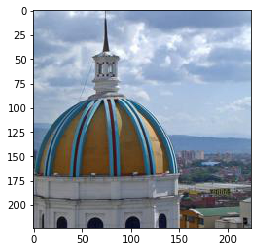

In [31]:
def prediction(dataloader):
  
  images,labels = iter(dataloader).next()
  prediction = classes[torch.argmax(model(images),dim=1).item()]
  img = return_real_image(images)
  plt.imshow(img)
  
  return images
 
images = prediction(eval_dataloader)

## 5. Occlusion Analysis

What is the probability that the image will be still classified as dome if we delete a certain region of the image. 

if the area where the actual dome is shows zero probability after occlusion then our model is correctly classifying.

In [32]:
outputs = model(images)
print('Shape:',outputs.size())
outputs = nn.functional.softmax(outputs,dim=1)
prob, index = torch.max(outputs,dim=1)
print('the class is indetified as %s with probability of %.2f' % (classes[index.item()],prob.item()))

Shape: torch.Size([1, 1000])
the class is indetified as dome with probability of 0.91


In [33]:
images[0].size()

torch.Size([3, 224, 224])

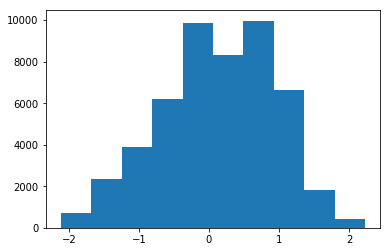

In [34]:
numpy_img = images[0][0].numpy()
plt.hist(numpy_img.reshape(-1,1))
plt.show()

**Function below showing the convolution with particular kernel and stride**

Time Elapsed: 2.43


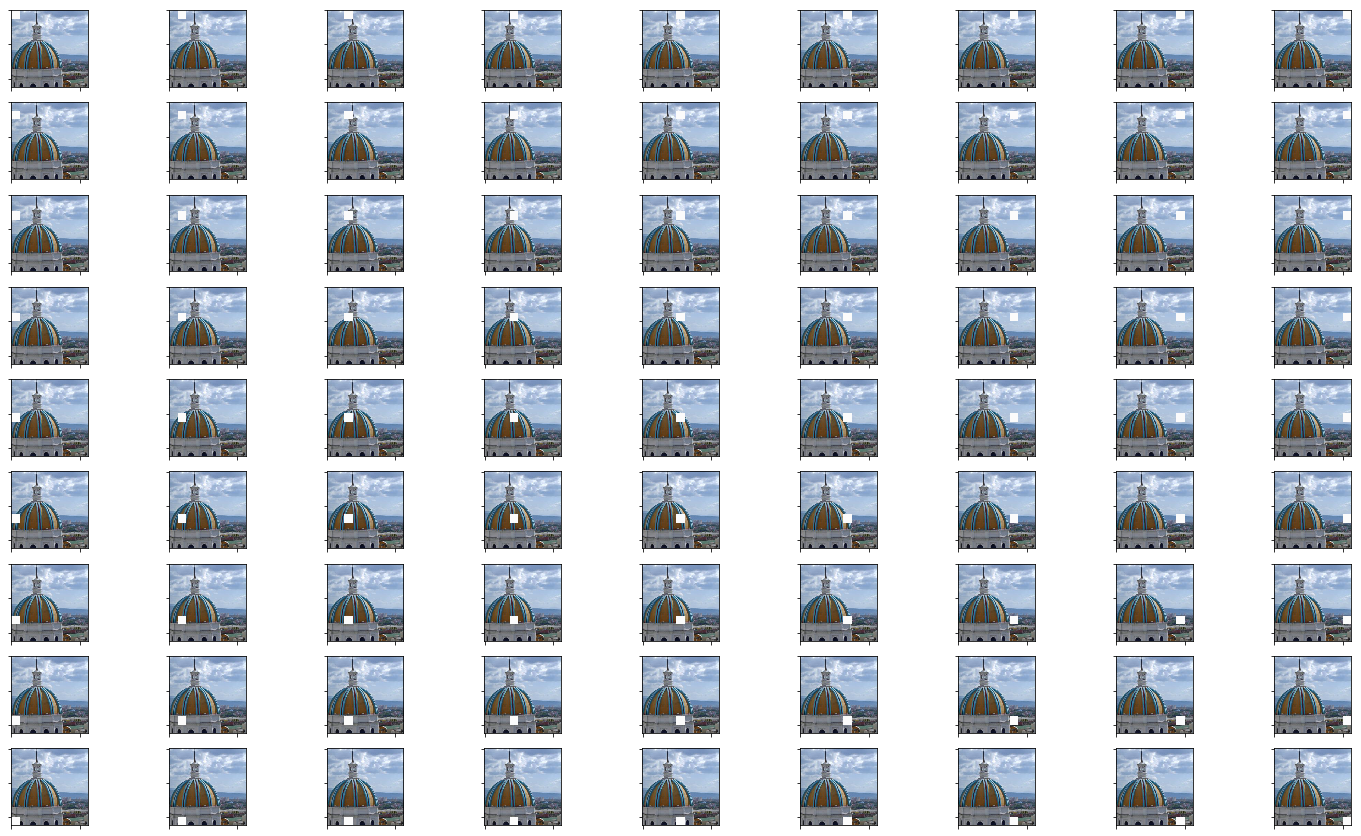

In [35]:
start_time = time.time()

def convolution_operation(images, kernel=25,stride=25,pixel=5.0):
  plt.figure(figsize=(25,15))
  img = return_real_image(images)

  no_convolutions_x = img.shape[0]//kernel
  no_convolutions_y = img.shape[1]//kernel

  remainder_x = img.shape[0] % kernel
  remainder_y = img.shape[1] % kernel
  w_start = 0
  w_end = kernel

  h_start = 0
  h_end = kernel
  counter = 1
  for i in range(no_convolutions_y+1):

    if i == no_convolutions_y:
      h_end -= (stride - remainder_y)

    for j in range(no_convolutions_x+1):

      if j == no_convolutions_x:
        w_end -= (stride - remainder_x)

      img_copied = copy.deepcopy(img)
      ax = plt.subplot(no_convolutions_y+1,no_convolutions_x+1,counter)
      counter += 1
      img_copied[h_start:h_end,w_start:w_end,:] = pixel
      ax.imshow((img_copied* 255).astype(np.uint8))
      ax.set_yticklabels([])
      ax.set_xticklabels([])
      w_start += stride
      w_end += stride

    h_start += stride  
    h_end += stride

    w_start = 0
    w_end = kernel
    
convolution_operation(images)

stop_time = time.time()
print('Time Elapsed: %.2f' % (stop_time-start_time))

**Further Development**: make a video output of this operation

This fucntion below is the occlusion analyis for a given tensor images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 52.4 s, sys: 2.49 s, total: 54.8 s
Wall time: 54.8 s


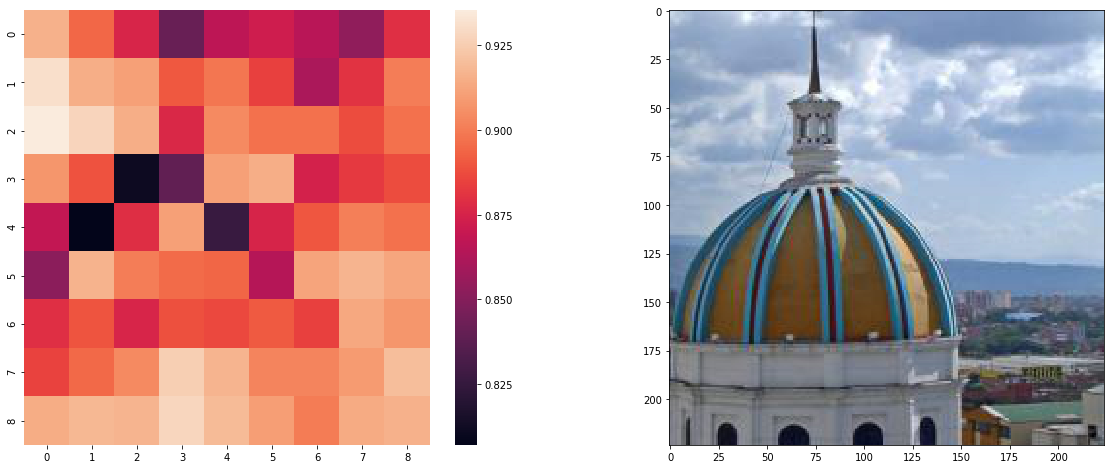

In [36]:
%%time 

def occlusion_analysis(images, kernel=25,stride=25, pixel=0.5):
  width, height = images.shape[-2], images.shape[-1]

  no_convolutions_x = width//kernel
  no_convolutions_y = height//kernel
  prediction = np.zeros(shape=(no_convolutions_x+1,no_convolutions_y+1))

  remainder_x = width % kernel
  remainder_y = height % kernel

  h_start = 0
  h_end = kernel

  for i in range(no_convolutions_y+1):

    w_start = 0
    w_end = kernel

    if i == no_convolutions_y:
      h_end -= (stride - remainder_y)

    for j in range(no_convolutions_x+1):
      if j == no_convolutions_x:
        w_end -= (stride - remainder_x)

      img_copied = copy.deepcopy(images)
      img_copied[:,:, h_start:h_end,w_start:w_end] = pixel
      outputs = model(img_copied.float())

      outputs = nn.functional.softmax(outputs,dim=1)
      prob, index = torch.max(outputs,dim=1)
      prediction[i,j] = prob.item()

      w_start += stride
      w_end += stride

    h_start += stride  
    h_end += stride
    
  return prediction
    
prediction = occlusion_analysis(images)
plt.figure(figsize=(20,8))
ax1 = plt.subplot(1,2,1)
ax1 = sns.heatmap(prediction)

ax2 = plt.subplot(1,2,2)
ax2.imshow(return_real_image(images))

## 6. Visualization of the filters 

In [37]:
model2 = models.alexnet(pretrained=True)
print(model2)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:02<00:00, 98286274.18it/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [38]:
prediction = model2.features[0].weight.data
prediction.size()

torch.Size([64, 3, 11, 11])

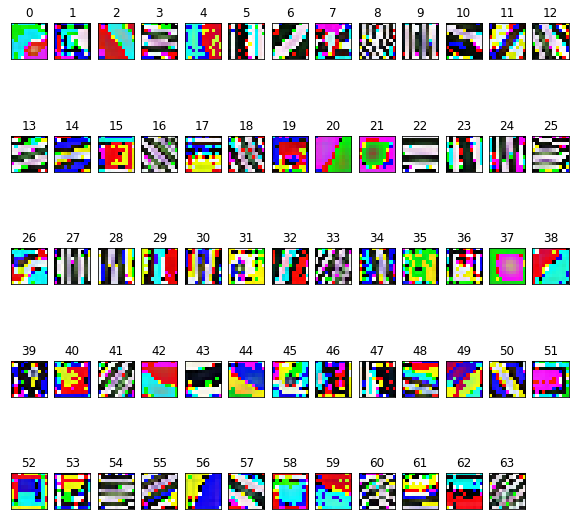

In [39]:
def plot_weigths(model, layer=0, n_rows= 5):
  weights = model.features[0].weight.data
  weights = prediction.detach().numpy()

  no_filter = weights.shape[0]
  plt.figure(figsize=(10,10))
  n_columns = np.ceil(no_filter/n_rows)
  for f in range(no_filter):
    img = weights[f]
    img = np.transpose(img,(1,2,0))
    ax = plt.subplot(n_rows,n_columns,f+1)
    ax.imshow((img*255).astype(np.uint8))
    ax.set_title(f)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plot_weigths(model2)    